# Импорт библиотек

In [7]:
from subprocess import check_output
from tqdm import tqdm_notebook
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import time

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"housemdrnd","key":"0123456789abcdef"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

# Вспомогательные функции

In [8]:
def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

In [9]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Функция отыскания прямоугольной оболочки для данной маски

In [ ]:
def search_shell(matr):
    i_min, i_max = 0, matr.shape[0] - 1
    j_min, j_max = 0, matr.shape[1] - 1
    for i in range(matr.shape[0]):
        if matr[i].sum()!=0:
            i_min = i
            break
    for i in range(i_min, matr.shape[0]):
        if matr[i].sum()==0:
            i_max = i-1
            break

    for j in range(matr.shape[1]):
        if matr[:, j].sum()!=0:
            j_min = j
            break
    for j in range(j_min, matr.shape[1]):
        if matr[:, j].sum()==0:
            j_max = j-1
            break
    return i_min, i_max, j_min, j_max

# Загрузка масок из решений

In [10]:
subs = []

In [ ]:
files = os.listdir('/content/drive/My Drive/understanding_cloud_organization/new')
files

In [ ]:
for i in tqdm_notebook(range(len(files)), total=len(files)):
    subs.append(pd.read_csv('/content/drive/My Drive/understanding_cloud_organization/new/' + files[i], keep_default_na=True))
    subs[i]['ImageId'] = subs[i]['Image_Label'].apply(lambda x: x.split('_')[0])
    subs[i]['EncodedPixels'].replace({np.nan: ''}, inplace=True)

# Построение оболочек для предсказанных масок и отправка на Kaggle для проверки

In [ ]:
mask = []
for i in range(len(subs)):
    sub_1 = subs[i].copy(deep=True)
    enc_pixels_list = []
    for index, row in tqdm_notebook(sub_1.iterrows(), total = len(sub_1)):
        mask_rle_1 = row['EncodedPixels']
        mask_1 = rle2mask(mask_rle_1, (350, 525, 3))
        cnt_component, _ = cv2.connectedComponents(mask_1.astype(np.uint8))
        if (cnt_component <= 2) and (mask_1.sum() !=0):
            imin, imax, jmin, jmax  = search_shell(mask_1)
            if (imin!=-1) and (jmin!=-1):
                mask_1[imin:imax, jmin:jmax] = 1 
        enc_pixels_list.append(mask2rle(mask_1))

    sub_1['EncodedPixels'] = enc_pixels_list
    sub_1.drop('ImageId', axis=1, inplace=True)
    sub_1.to_csv(f'shell_{files[i]}.csv', index=None)
    fname = f'shell_{files[i]}.csv'
    msg = f"SHELL {files[i]}"
    time.sleep(50)
    os.system(f"kaggle competitions submit -c understanding_cloud_organization -f {fname} -m \"{msg}\"")

# Пример работы 

In [ ]:
import zipfile
zip_file = '/content/drive/My Drive/test_img.zip'  
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

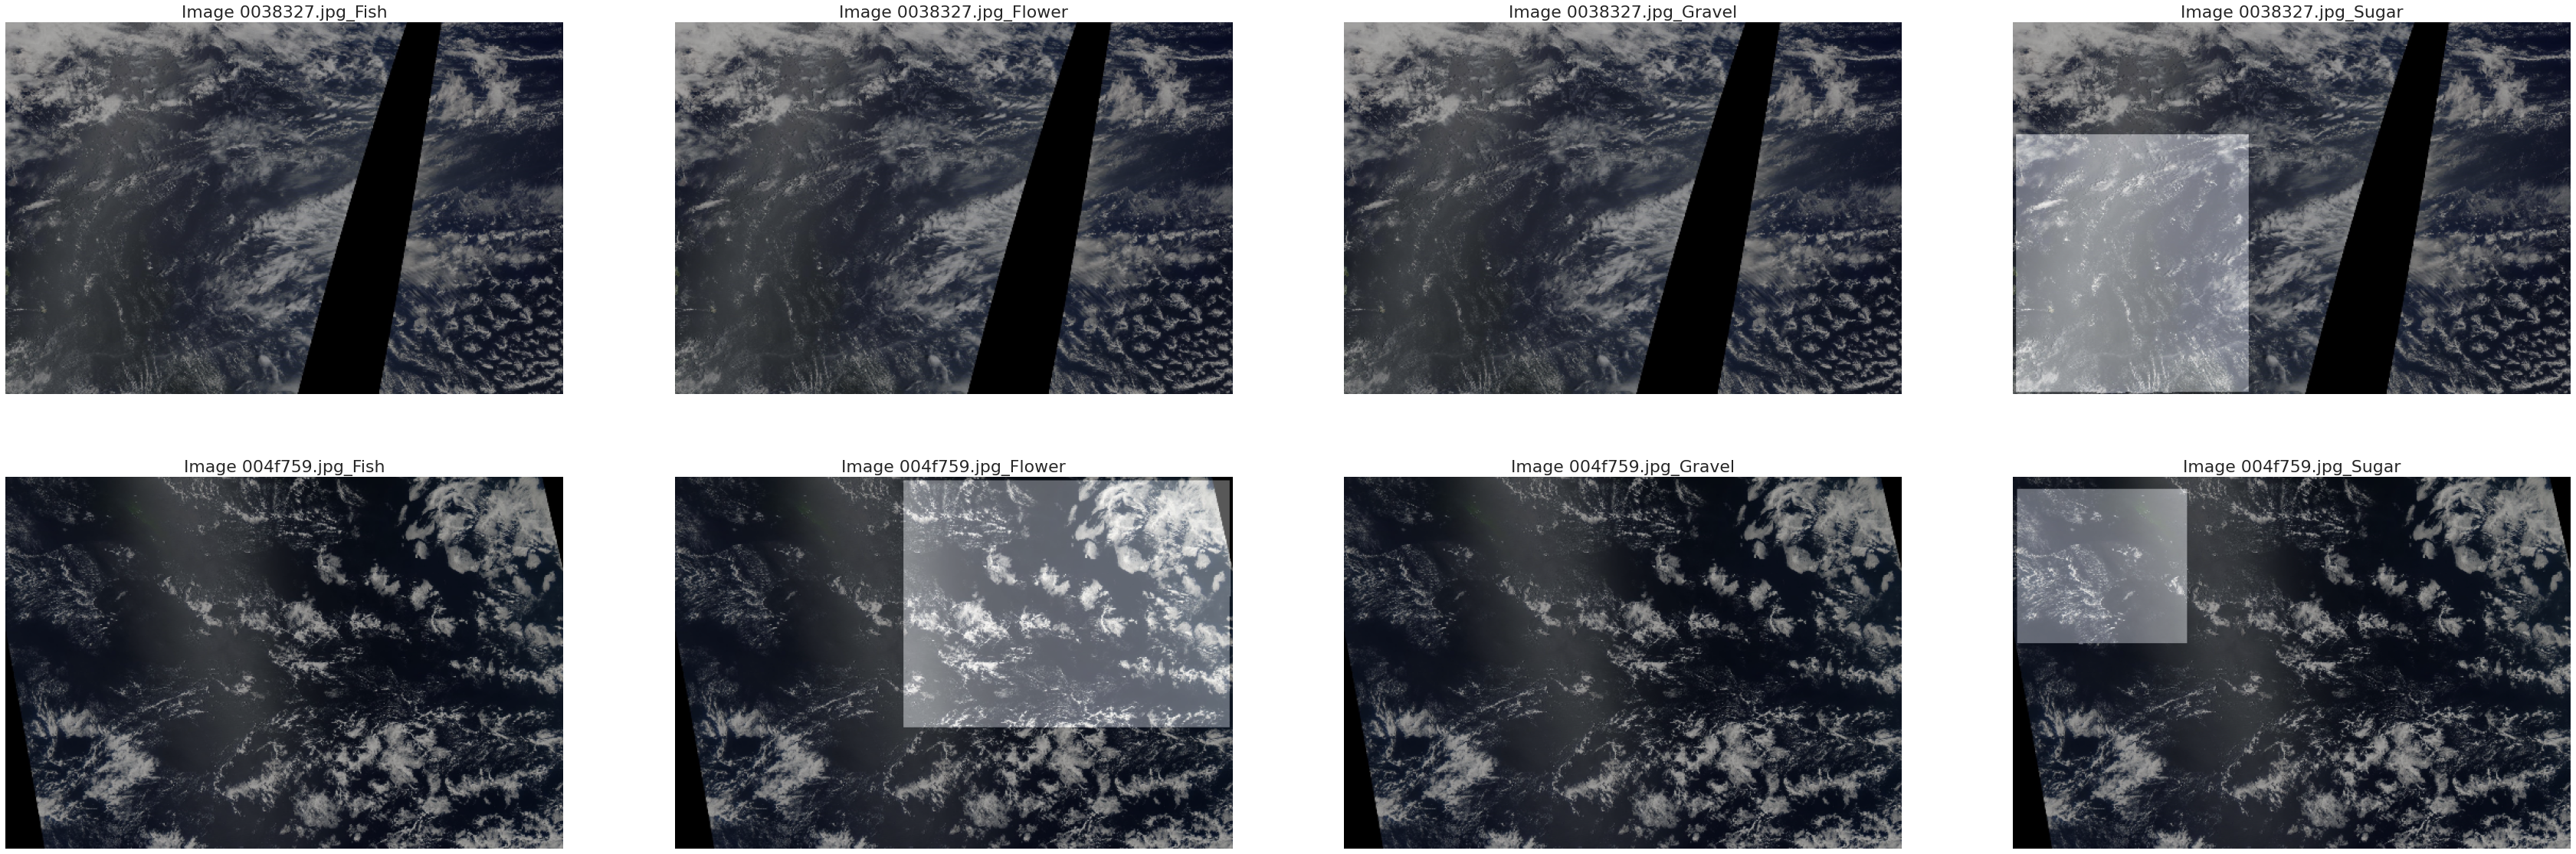

In [ ]:
sns.set_style("white")
plt.figure(figsize=[60, 20])
for index, row in sub_1[8:16].iterrows():
    img = cv2.imread(f"/content/test_img/test_images/{row['image']}")[...,[2, 1, 0]]
    img = cv2.resize(img, (525, 350))
    mask_rle = row["EncodedPixels"]
    try: 
        mask = rle2mask(mask_rle, img.shape)
    except:
        mask = np.zeros((1400, 2100))
    plt.subplot(2, 4, index+1-8)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.35, cmap='gray')
    plt.title(f"Image {row['Image_Label']}", fontsize=22)
    plt.axis('off')    

plt.savefig('clds' + 'shell', dpi = 400)
plt.show()

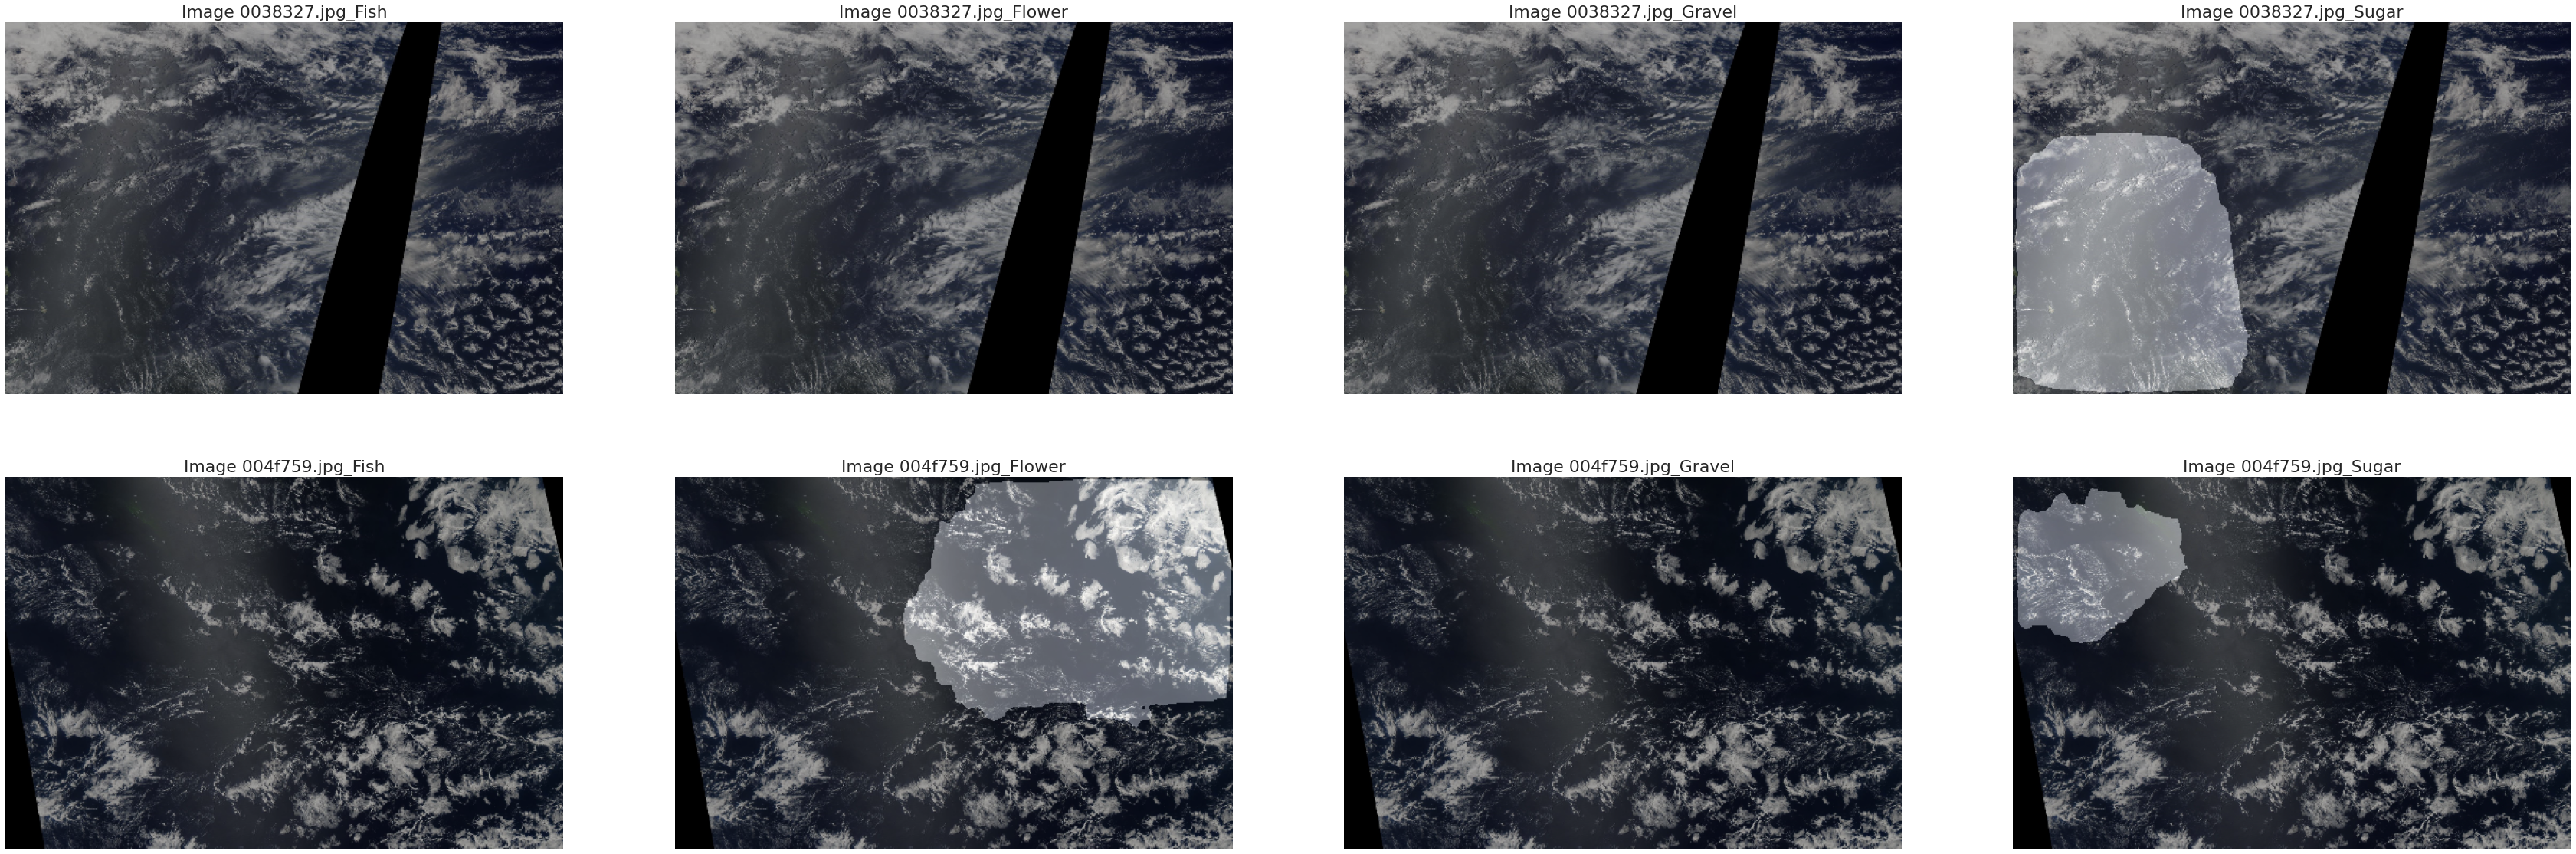

In [ ]:
sns.set_style("white")
plt.figure(figsize=[60, 20])
for index, row in subs[0][8:16].iterrows():
    img = cv2.imread(f"/content/test_img/test_images/{row['image']}")[...,[2, 1, 0]]
    img = cv2.resize(img, (525, 350))
    mask_rle = row["EncodedPixels"]
    try: 
        mask = rle2mask(mask_rle, img.shape)
    except:
        mask = np.zeros((1400, 2100))
    plt.subplot(2, 4, index+1-8)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.35, cmap='gray')
    plt.title(f"Image {row['Image_Label']}", fontsize=22)
    plt.axis('off')    

plt.savefig('clds' + 'test', dpi = 400)
plt.show()